# Fig. 7: S/N of the fiducial model with and without a single specie

In [41]:
import pickle
from matplotlib import pyplot as plt
import os
from astropy import units as u
import sys
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec
from astropy.stats import sigma_clip

In [42]:
vsys = -24.452e3 * (u.m/u.s) # ?+23
kp = 200.7e3 * (u.m/u.s) # ?+23
LABELSIZE=11

In [43]:
APJ_SINGLE_COL = 3.5
APJ_DOUBLE_COL = 7.
TEXTSIZE=12
TICKSIZE=12

In [44]:
def get_planet_params(data, trial_kp, trial_vsys):
    yy, xx = np.meshgrid(trial_kp, trial_vsys)
    indmax = np.unravel_index(data.argmax(), data.shape)
    vsys_max, kp_max = xx[indmax], yy[indmax]
    value_max = data[indmax]
    return vsys_max, kp_max, value_max

In [45]:

def plot_detection_matrix(data, dkp_all, dvsys_all, kp, vsys, mode='snr', title='', interp_method='bicubic', ax='None', **kwargs):
    """Plot Kp-vsys map."""
    extend='neither'
    quantity = r'S/N'
    cmap = kwargs.pop('cmap', 'Reds_r')
    markercolor = 'w'
    snr_min = kwargs.pop('snr_min', np.nanmin(data))
    snr_max = kwargs.pop('snr_max', np.ceil(10*np.nanmax(data))/10.)

    snr_step = kwargs.pop('snr_step', 0.25)
    ncolors = int(1+(snr_max - snr_min)/snr_step)
    if ncolors > 256:
        ncolors = 256

    cmap = mpl.colormaps[cmap]
    cmap.set_bad('gray',1.)
    bounds = np.round(np.linspace(snr_min, snr_max, ncolors), 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    # Set appropriate ranges
    dvsys = dvsys_all[1]-dvsys_all[0]
    dkp = dkp_all[1]-dkp_all[0]
    extent=[
        (dvsys_all[0]-dvsys/2.)/1e3,
        (dvsys_all[-1]+dvsys/2.)/1e3,
        (dkp_all[0]-dkp/2.+kp)/1e3,
        (dkp_all[-1]+dkp/2.+kp)/1e3
    ]

    # Plot matrix
    im = ax.imshow(data.T, origin='lower',
                   extent=extent,
                   aspect='auto', cmap=cmap,
                   norm=norm, interpolation=interp_method)
    ax.tick_params(labelsize=TEXTSIZE)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.0)

    #ax.set_xlabel(r'System velocity (km/s)', size=TEXTSIZE)
    #ax.set_ylabel(r'$\rm{K}_{\rm{p}}$ (km/s)', size=TEXTSIZE)

    # Plot dotted lines to the planet's estimate (vsys, kp)
    bads = np.isnan(data)
    data_masked = np.copy(data)
    data_masked[bads] = 0.
    vsys_max, kp_max, value_max = get_planet_params(data_masked, kp+dkp_all, dvsys_all) # find min instead of max in this mode

    ax.plot([vsys/1e3, vsys/1e3], [extent[2], (kp-15e3)/1e3], ls='--', color='w', lw=2, label='expected')
    ax.plot([vsys/1e3, vsys/1e3], [(kp+15e3)/1e3, extent[3]-25], ls='--', color='w', lw=2)
    ax.plot([extent[0], (vsys-10e3)/1e3], [kp/1e3, kp/1e3], ls='--', color='w', lw=2)
    ax.plot([(vsys+10e3)/1e3, extent[1]], [kp/1e3, kp/1e3], ls='--', color='w', lw=2)
    ax.scatter( (vsys_max)/1e3, (kp_max)/1e3, marker="8", s=20, facecolors='w', edgecolors='k', linewidths=0.5, label='maximum SNR')
    
    # Add text with highest SNR
    ax.annotate('{} = {:.1f}\n'.format(quantity, value_max),
                (0.5, 0.975), xycoords='axes fraction', ha='center', va='top', size=TEXTSIZE, color='w', fontweight='bold')

    # Plot colorbar
    cbar = plt.colorbar(mappable=im, cax=cax,extend=extend)
    #cbar.set_label('{}'.format(quantity), size=TEXTSIZE)
    cax.tick_params(labelsize=TEXTSIZE)

    # Set title
    #leg = ax.legend(fontsize=TEXTSIZE, frameon=False)
    #plt.setp(leg.get_texts(), color='w')
    ax.set_xlim(dvsys_all[0]/1e3, dvsys_all[-1]/1e3)
    ax.set_ylim(kp/1e3+dkp_all[0]/1e3, kp/1e3+dkp_all[-1]/1e3)
    return ax, cax, cbar

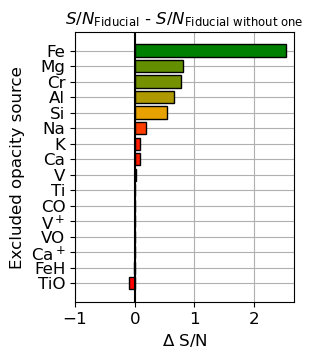

In [46]:
species = [
    'Fe',
    '39K__Allard',
    '23Na__Allard',
    'Ti-O-NatAbund__Toto',
    '51V-16O__HyVO',
    'FeH',
    'Ti',
    'V',
    'Ca',
    'Ca_p',
    'Si',
    'Mg',
    'Cr',
    'Al',
    'V_p',
    'CO',
]

species_label = np.array([
    'Fe',
    'K',
    'Na',
    'TiO',
    'VO',
    'FeH',
    'Ti',
    'V',
    'Ca',
    r'Ca$^+$',
    'Si',
    'Mg',
    'Cr',
    'Al',
    r'V$^+$',
    'CO',
])

obs_id= 'WASP-189_2023A_2023_06_09_2024A_2024_04_19'
ncols = int(np.ceil(np.sqrt(float(len(species)))))
nrows = int(np.ceil(np.sqrt(float(len(species)))))

dirin_xcor = '../data/xcor_out'
scaling = 1 # 0.38
dr_id = 'NPC_7_mp_70_ccw'
ns = -1

ncols = 4
nrows = 3

snr_fiducial = 9.755
snr_species = np.zeros(len(species)) * np.nan
for ns in range(len(species)):
        dirin = f'{dirin_xcor}/{obs_id}/W189b_pRT_1D_Yan22_chem_eq_all_without_{species[ns]}/{dr_id}'
        trial_kp, trial_vsys, snrmatrix = pickle.load(open(os.path.join(dirin, 'snrmap.pkl'), 'rb'))
        snr_species[ns] = snrmatrix.max()  # / np.std(sigma_clip(signalmap, 2))

# Define the colors for the colormap
colors = [(0, 1, 0), (1, 0, 0), (1, 0, 0)]  # Green to Red
cmap_name = 'green_to_red'

cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
my_cmap=LinearSegmentedColormap.from_list('rg',["r", "orange", "g"], N=256) 

fig, ax = plt.subplots(figsize=(APJ_SINGLE_COL, APJ_SINGLE_COL))
ind_sorted = np.argsort(snr_species)[::-1]
colors = my_cmap(snr_fiducial - snr_species[ind_sorted])
ax.barh(species_label[ind_sorted], snr_fiducial - snr_species[ind_sorted], color=colors, edgecolor='black', linewidth=1.)

ax.set_xlabel(r'$\Delta$ S/N', size=TEXTSIZE)
ax.set_ylabel(r'Excluded opacity source', size=TEXTSIZE)
ax.set_xticks([-1,0,1,2])
ax.tick_params(axis='x', labelsize=TICKSIZE)
ax.tick_params(axis='y', labelsize=TICKSIZE)
ax.axvline(x=0, color='k')
ax.set_axisbelow(True)
ax.grid(True)

plt.subplots_adjust(right=0.75)

ax.set_title(r'$S/N_{\rm{Fiducial}}$ - $S/N_{\rm{Fiducial \ without \ one}}$', size=TEXTSIZE)

plt.savefig(f'../figures/Fig7_snr_diff_fiducial_without_one.pdf', bbox_inches='tight')
plt.savefig(f'../figures/Fig7_snr_diff_fiducial_without_one.png', dpi=200, bbox_inches='tight')
plt.show()